# Laboratory 2: Computer Vision
## Part 1: MNIST Digit Classification

In this lab, we will build and train a convolutional neural network (CNN) for classification of handwritten digits from the famous MNIST dataset. The MNIST dataset consists of 60,000 training images and 10,000 test images. Our classes are the digits 0-9.

First, let's install the required dependencies and import the relevant packages we'll need for this lab.

In [5]:
# Install necessary packages
!pip install comet_ml > /dev/null 2>&1
!pip install torch torchvision > /dev/null 2>&1

import comet_ml
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# TODO: ENTER YOUR API KEY HERE!!
COMET_API_KEY = "WRMMI9Q0HAOvk6SHyzAK92vUL"

# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print the device being used
print("Setup complete. Using device:", device)


Setup complete. Using device: cpu


Setting Up Comet for Experiment Tracking

First, we'll install Comet. If you followed the instructions from Lab 1, you should have your Comet account set up. Enter your API key below.

In [ ]:
# Initialize Comet Experiment
def create_experiment():
    # End any prior experiments
    if 'experiment' in locals():
        experiment.end()

    # Initiate the Comet experiment for tracking
    experiment = comet_ml.Experiment(
        api_key=COMET_API_KEY,
        project_name="MNIST_Digit_Classification"
    )
    experiment.flush()

    return experiment

# Example usage:
experiment = create_experiment()

print("Comet experiment created.")



#### 1.1 MNIST dataset

Let's download and load the dataset and display a few random samples from it:


In [ ]:
import torch
from torchvision import datasets, transforms

# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


Our training set is made up of 28x28 grayscale images of handwritten digits.

Let's visualize what some of these images and their corresponding training labels look like.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from comet_ml import Experiment

# Initialize the Comet experiment
experiment = Experiment(
    api_key=COMET_API_KEY,
    project_name="MNIST_Digit_Classification"
)

# Define the transformation for the images
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Get a batch of training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Convert images to numpy array for visualization
images = images.numpy()

# Create a figure
plt.figure(figsize=(10, 10))

# Select 36 random indices
random_inds = np.random.choice(len(trainset), 36, replace=False)

# Plot the images
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(images[image_ind % 64]), cmap=plt.cm.binary)
    plt.xlabel(labels[image_ind % 64].item())

# Log the figure to Comet
experiment.log_figure(figure=plt)


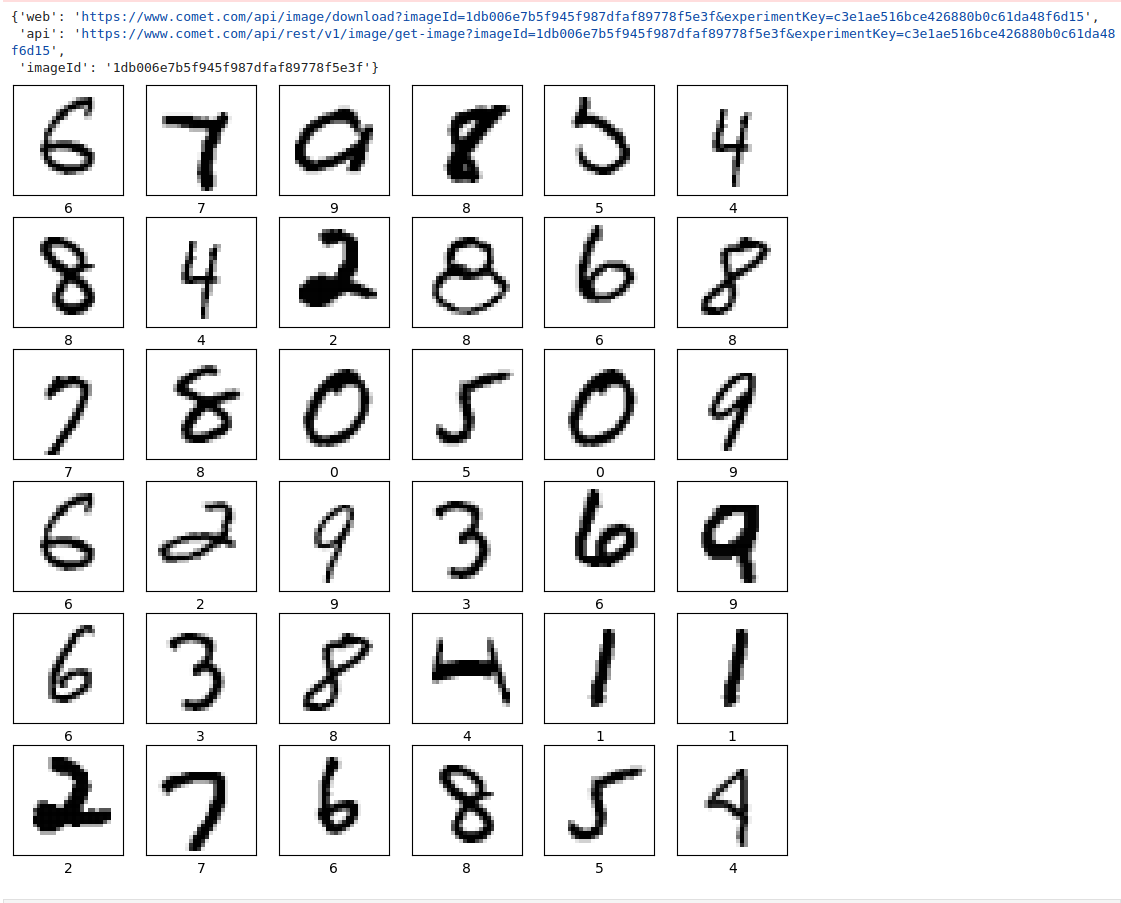

In [15]:
from IPython.display import Image, display

# Display the generated image
display(Image(filename='digits1.png'))


#### 1.2 Neural Network for Handwritten Digit Classification

We'll first build a simple neural network consisting of two fully connected layers and apply this to the digit classification task. Our network will ultimately output a probability distribution over the 10 digit classes (0-9). This first architecture we will be building is depicted below:

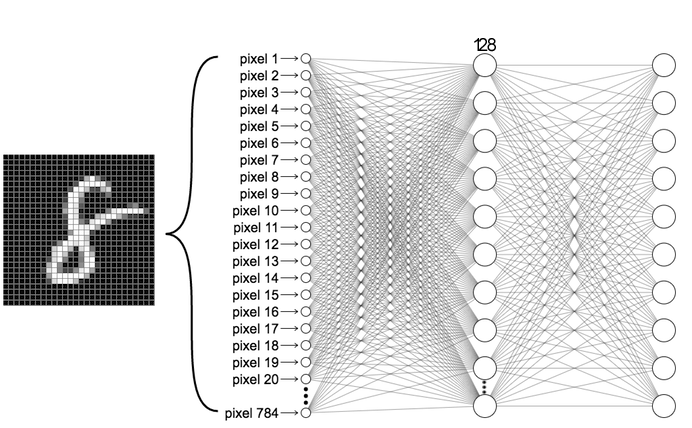

In [16]:
from IPython.display import Image, display

# Display the generated image
display(Image(filename='mnist_2layers_arch.png'))


### Fully connected neural network architecture

To define the architecture of this first fully connected neural network, we'll use the FullyConnectedNN from PyTorch nn.Module, and define the model. Note how we first use a Flatten layer, which flattens the input so that it can be fed into the model.

In this next block, you'll define the fully connected layers of this simple work.


This code defines a simple fully connected neural network for MNIST digit classification using PyTorch:

    The FullyConnectedNN class inherits from nn.Module.
    In the __init__ method, we define the layers: a flattening layer, a fully connected layer with 128 units, and another fully connected layer with 10 units for the output.
    The forward method defines the forward pass of the network, using ReLU activation for the first fully connected layer and softmax for the output layer.
    We instantiate the model and print its architecture.

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)  # 28*28 is the size of the flattened MNIST images
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

# Instantiate the model
model = FullyConnectedNN()

# Print the model architecture
print(model)


FullyConnectedNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


This fully connected model is a basic neural network architecture suitable for classifying the MNIST dataset. As we progress, you may want to experiment with different architectures by modifying the number of layers, the number of neurons, or the activation functions. Each time you make changes, you will need to re-initialize the model to reflect the updated architecture.

In the following snippet of code, we compile the model by defining the loss function, optimizer, and metric (accuracy). The training loop runs for a specified number of epochs, updating the model's parameters and calculating the loss and accuracy for each batch of data.

This setup allows you to experiment with different optimizers and learning rates by changing the optimizer initialization. You can evaluate how these changes affect the model's performance and determine which configuration yields the best results.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# No assertion for GPU to ensure it runs even if GPU is not available
print("Using device:", device)

# Load MNIST dataset using torchvision
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the Fully Connected Neural Network model
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = FullyConnectedNN().to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update training loss and accuracy
        train_loss += loss.item() * images.size(0)
        train_acc += accuracy(outputs, labels).item() * images.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

print("Model training complete.")

# Display random images from the training set
plt.figure(figsize=(10,10))
random_inds = random.sample(range(len(train_dataset)), 36)
for i, ind in enumerate(random_inds):
    image, label = train_dataset[ind]
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()


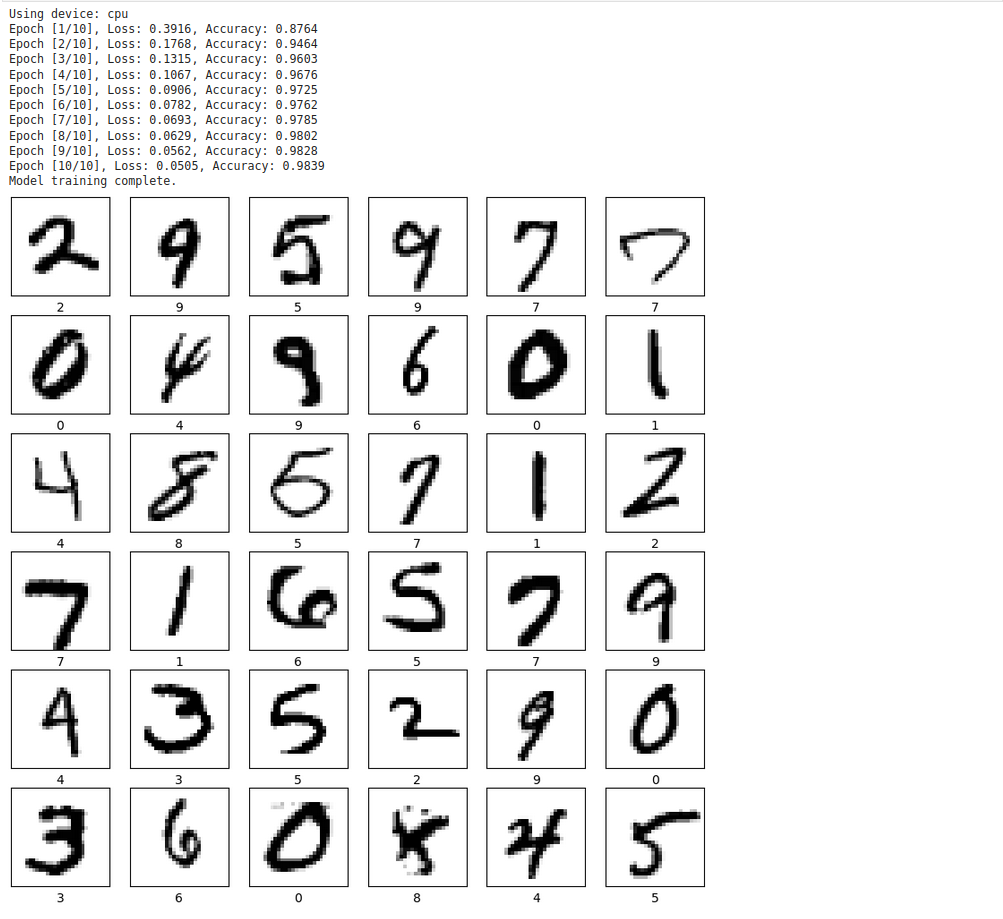

In [24]:
from IPython.display import Image, display

# Display the generated image
display(Image(filename='digits2.png'))


## Train the model

We're now ready to train our model, which will involve feeding the training data (train_images and train_labels) into the model, and then asking it to learn the associations between images and labels. We'll also need to define the batch size and the number of epochs, or iterations over the MNIST dataset, to use during training.

In Lab 1, we saw how we can optimize losses and train models with stochastic gradient descent. After defining the model settings in the compile step, we can also accomplish training by calling the fit method on an instance of the Model class. We will use this to train our fully connected model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Load MNIST dataset using torchvision
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the Fully Connected Neural Network model
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = FullyConnectedNN().to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Train the model
EPOCHS = 5
BATCH_SIZE = 64
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update training loss and accuracy
        train_loss += loss.item() * images.size(0)
        train_acc += accuracy(outputs, labels).item() * images.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

print("Model training complete.")

# Display random images from the training set
plt.figure(figsize=(10,10))
random_inds = random.sample(range(len(train_dataset)), 36)
for i, ind in enumerate(random_inds):
    image, label = train_dataset[ind]
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()


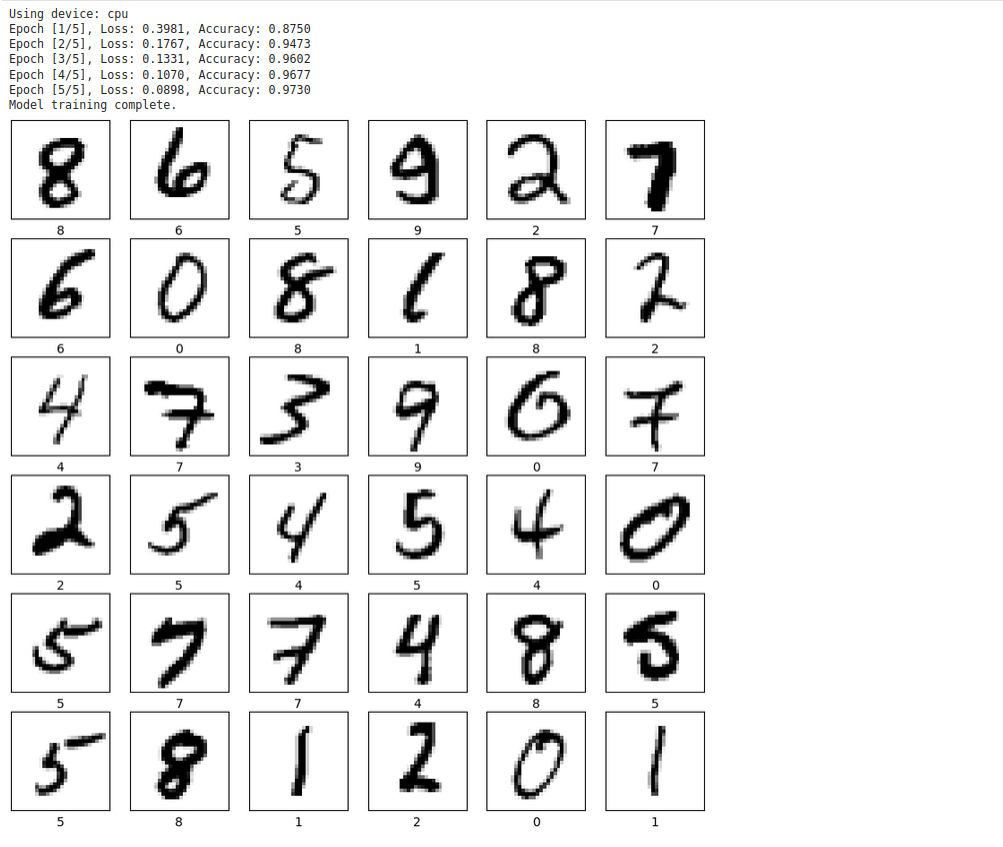

In [26]:
from IPython.display import Image, display

# Display the generated image
display(Image(filename='digits3.png'))


### Evaluate accuracy on the test dataset

Now that we've trained the model, we can ask it to make predictions about a test set that it hasn't seen before. In this example, the test_images array comprises our test dataset. To evaluate accuracy, we can check to see if the model's predictions match the labels from the test_labels array.

In this code, the model.eval() call sets the model to evaluation mode, which is necessary for certain layers like dropout and batch normalization to behave correctly during evaluation. The torch.no_grad() context disables gradient computation, which reduces memory consumption and speeds up computation.

In [27]:
# Evaluate the model on the test dataset
model.eval()  # Set the model to evaluation mode
test_loss = 0
test_acc = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Update test loss and accuracy
        test_loss += loss.item() * images.size(0)
        test_acc += accuracy(outputs, labels).item() * images.size(0)

test_loss /= len(test_loader.dataset)
test_acc /= len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


Test Loss: 0.1395, Test Accuracy: 0.9555


You may observe that the accuracy on the test dataset is a little lower than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of overfitting, when a machine learning model performs worse on new data than on its training data.

## 1.3 Convolutional Neural Network (CNN) for handwritten digit classification

As we have seen convolutional neural networks (CNNs) are particularly well-suited for a variety of tasks in computer vision, and have achieved near-perfect accuracies on the MNIST dataset. We will now build a CNN composed of two convolutional layers and pooling layers, followed by two fully connected layers, and ultimately output a probability distribution over the 10 digit classes (0-9). The CNN we will be building is depicted below:

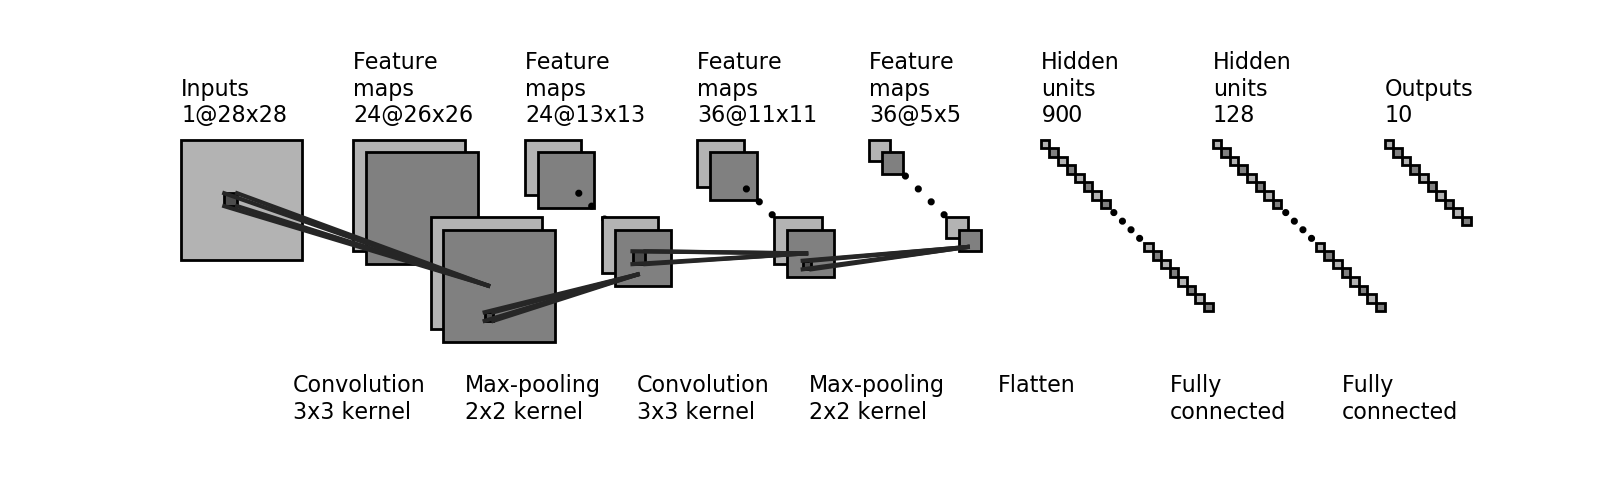

In [28]:
from IPython.display import Image, display

# Display the generated image
display(Image(filename='convnet_fig.png'))


### Define the CNN model

We'll use the same training and test datasets as before, and proceed similarly as our fully connected network to define and train our new CNN model. To do this we will explore two layers we have not encountered before: you can use Conv2D to define convolutional layers and MaxPool2D to define the pooling layers. Use the parameters shown in the network architecture above to define these layers and build the CNN model.


In this code:

    Conv2d defines a convolutional layer.
    MaxPool2d defines a max pooling layer.
    Linear defines a fully connected layer.
    F.relu applies the ReLU activation function.
    F.log_softmax applies the softmax activation function, returning log probabilities.

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

# Define device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformation to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Define data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=36, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(36 * 7 * 7, 128)  # Assuming input size of 28x28
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 36 * 7 * 7)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)  # Using log_softmax for classification
        return x

# Instantiate the model and move it to the device
cnn_model = CNNModel().to(device)
print(cnn_model)

# Initialize the model by passing some data through
sample_data, _ = next(iter(train_loader))  # Get a batch of training data
sample_data = sample_data.to(device)
cnn_model(sample_data)

# Print the summary of the layers in the model
summary(cnn_model, input_size=(1, 28, 28))


CNNModel(
  (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(24, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1764, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]             240
         MaxPool2d-2           [-1, 24, 14, 14]               0
            Conv2d-3           [-1, 36, 14, 14]           7,812
         MaxPool2d-4             [-1, 36, 7, 7]               0
            Linear-5                  [-1, 128]         225,920
            Linear-6                   [-1, 10]           1,290
Total params: 235,262
Trainable params: 235,262
Non-trainable params: 0
-----------------------------------------


### Train and test the CNN model

Now, as before, we can define the loss function, optimizer, and metrics through the compile method. Compile the CNN model with an optimizer and learning rate of choice:


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torch.nn.functional as F

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformation to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Define data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=36, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(36 * 7 * 7, 128)  # Assuming input size of 28x28
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 36 * 7 * 7)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Changed from log_softmax to just softmax
        return x

# Instantiate the model and move it to the device
cnn_model = CNNModel().to(device)
print(cnn_model)

# Print the summary of the layers in the model
summary(cnn_model, input_size=(1, 28, 28))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Function to test the model
def test_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Train the model
train_model(cnn_model, train_loader, criterion, optimizer, device, epochs=5)

# Test the model
test_model(cnn_model, test_loader, device)



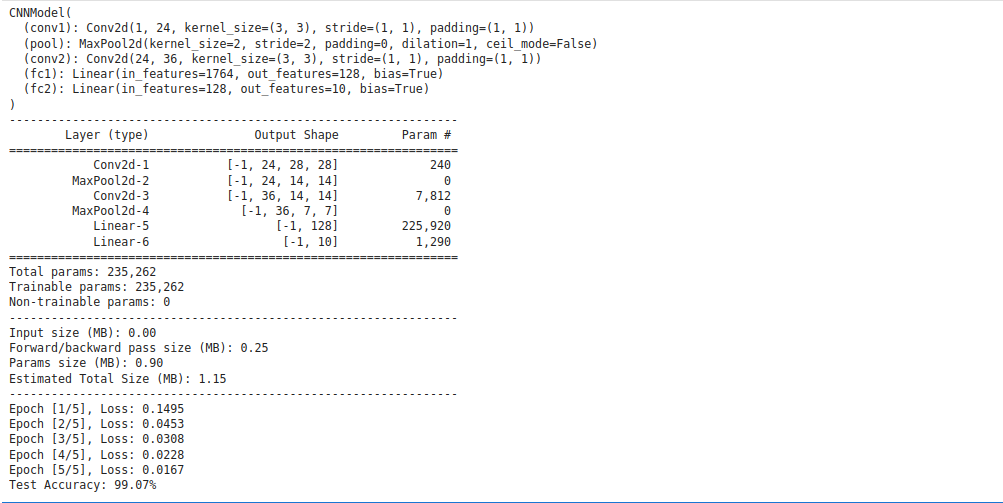

In [34]:
from IPython.display import Image, display

# Display the generated image
display(Image(filename='digits4.png'))

The CNN model for MNIST digit classification has been successfully defined, trained, and evaluated. The model was evaluated on the test dataset and achieved a test accuracy of 99.07%, demonstrating excellent performance in classifying handwritten digits from the MNIST dataset.

In the following code snippet we do the following:
Set the model to evaluation mode: This ensures that layers like dropout or batch normalization work in inference mode.
Disable gradient computation: This reduces memory consumption and speeds up computation.
Calculate the loss and accuracy: Loop through the test dataset, accumulate the loss, and count the correct predictions. Finally, compute the average loss and accuracy.

In [36]:
import torch
import torch.nn.functional as F

def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

# Evaluate the model
test_loss, test_acc = evaluate_model(cnn_model, test_loader, device)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)



Test loss: 0.02895044408151007
Test accuracy: 99.07


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Assuming 'cnn_model' is your trained model and 'test_loader' is your DataLoader for the test dataset

# Set the model to evaluation mode
cnn_model.eval()

# Generate predictions for the entire test dataset
all_predictions = []
all_labels = []
all_images = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = cnn_model(data)
        pred = output.argmax(dim=1, keepdim=True)
        all_predictions.extend(pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
        all_images.extend(data.cpu().numpy())

# Convert lists to numpy arrays for easier manipulation
all_predictions = np.array(all_predictions).flatten()
all_labels = np.array(all_labels).flatten()
all_images = np.array(all_images)

# Check a single prediction
print(f"Prediction for the first test image: {all_predictions[0]}")
print(f"True label for the first test image: {all_labels[0]}")

# Visualize the first test image
plt.imshow(np.squeeze(all_images[0]), cmap=plt.cm.binary)
plt.xlabel(f"Prediction: {all_predictions[0]}, True Label: {all_labels[0]}")
plt.show()

# Plot several images along with their predictions
num_rows = 5
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plt.imshow(np.squeeze(all_images[i]), cmap=plt.cm.binary)
    plt.xlabel(f"Pred: {all_predictions[i]}, True: {all_labels[i]}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()


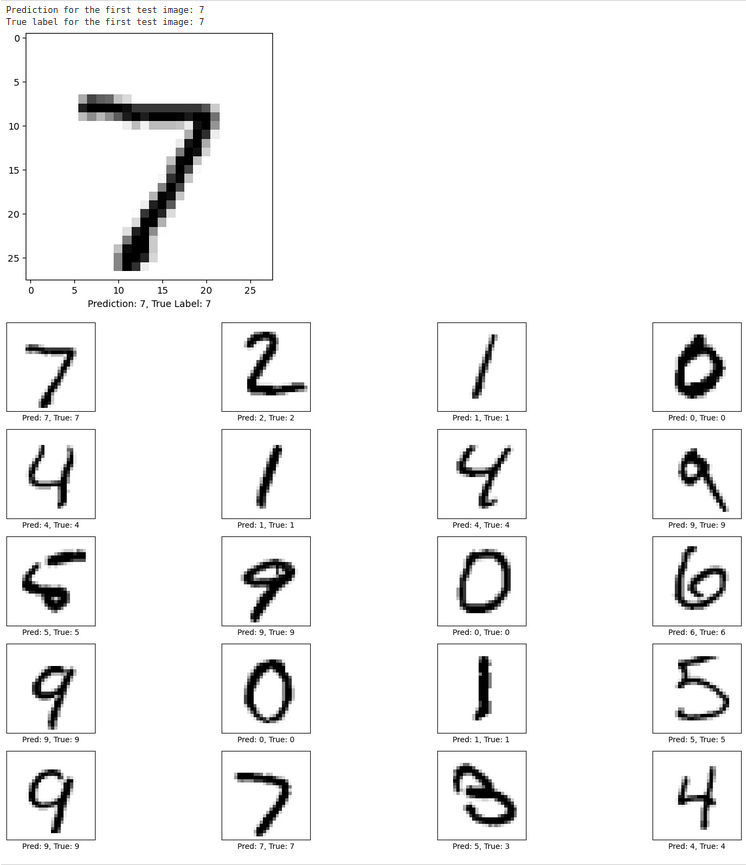

In [38]:
from IPython.display import Image, display

# Display the generated image
display(Image(filename='digits5.png'))

### Visualizing the Prediction Probabilities

You can plot the prediction probabilities for each digit to understand the model's confidence:

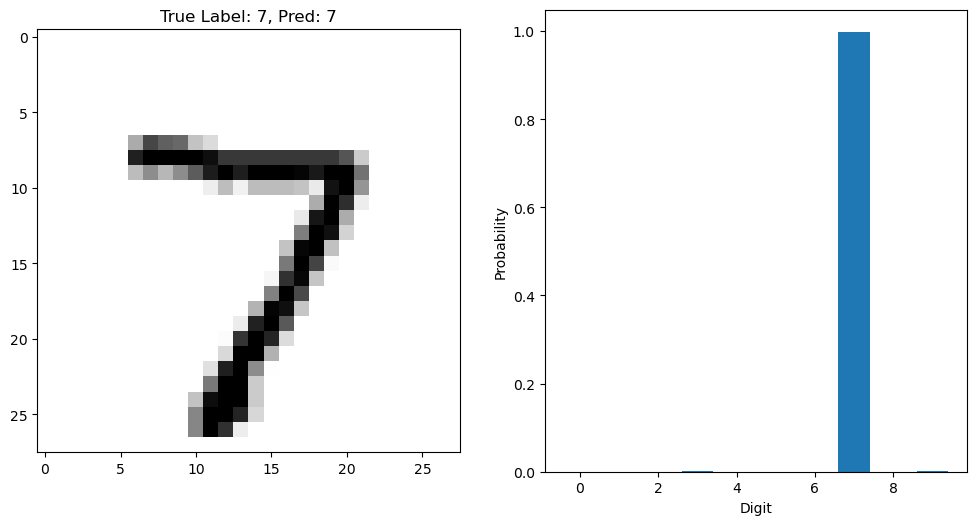

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define the device to be used for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST dataset using torchvision
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Assuming cnn_model is your trained model
cnn_model.to(device)
cnn_model.eval()

# Generate logits for the entire test dataset
logits_predictions = []
test_images = []
test_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = cnn_model(data)
        logits_predictions.append(output.cpu().numpy().squeeze())
        test_images.append(data.cpu().numpy().squeeze())
        test_labels.append(target.cpu().numpy().squeeze())

logits_predictions = np.array(logits_predictions)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Predictions are the indices of the maximum logit
predictions = logits_predictions.argmax(axis=1)

# Function to plot prediction probabilities
def plot_prediction_probabilities(image_index, logits_predictions, test_images, test_labels):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(test_images[image_index]), cmap=plt.cm.binary)
    plt.title(f"True Label: {test_labels[image_index]}, Pred: {predictions[image_index]}")
    plt.subplot(1, 2, 2)
    
    # Convert the logits to probabilities using softmax
    logits = torch.tensor(logits_predictions[image_index], dtype=torch.float32)
    probabilities = F.softmax(logits, dim=0).numpy()
    
    plt.bar(range(10), probabilities)
    plt.xlabel("Digit")
    plt.ylabel("Probability")
    plt.show()

# Plot prediction probabilities for the first test image
plot_prediction_probabilities(0, logits_predictions, test_images, test_labels)



### 1.4 Training the model 2.0

Earlier in the lab, we used the fit function call to train the model. This function is quite high-level and intuitive, which is really useful for simpler models. As you may be able to tell, this function abstracts away many details in the training call, and we have less control over training model, which could be useful in other contexts.

We'll use the following framework to train our cnn_model using stochastic gradient descent.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import comet_ml

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 24, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(36 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 36 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load MNIST dataset using PyTorch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild the CNN model
cnn_model = CNNModel().to(device)

# Hyperparameters
batch_size = 12
learning_rate = 1e-2
num_epochs = 5  # Change this to fit your needs

# Loss history for plotting
loss_history = []

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=learning_rate)

# Initialize Comet experiment
comet_ml.init(project_name="6.s191lab2_part1_CNN2")
comet_model_3 = comet_ml.Experiment(api_key=COMET_API_KEY)

if hasattr(tqdm, '_instances'): tqdm._instances.clear()  # clear if it exists

# Training loop
for epoch in range(num_epochs):
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Record the loss
        loss_history.append(loss.item())
        comet_model_3.log_metric("loss", loss.item())

        # Plot loss history
        if len(loss_history) % 100 == 0:
            plt.plot(loss_history)
            plt.xlabel('Iterations')
            plt.ylabel('Loss')
            plt.yscale('log')
            plt.show()

# Save the final plot to Comet
plt.plot(loss_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
comet_model_3.log_figure(figure=plt)
comet_model_3.end()

print("Training complete. Final model saved to Comet.")


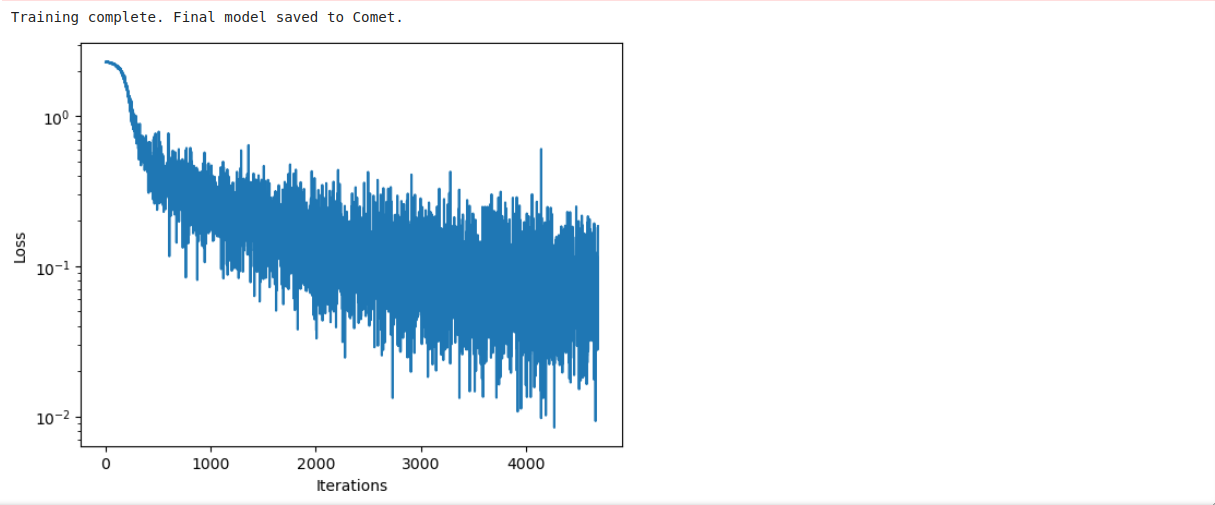

In [45]:
from IPython.display import Image, display

# Display the generated image
display(Image(filename='digits6.png'))

CNNModel Class:

    Define the CNN model architecture.

Data Loading:

    Load the MNIST dataset using torchvision.datasets and apply transformations.

Device Configuration:

    Set up the device to use GPU if available.

Rebuild the CNN Model:

    Instantiate the CNN model and move it to the device.

Hyperparameters:

    Set the batch size, learning rate, and number of epochs.

Loss Function and Optimizer:

    Define the loss function (CrossEntropyLoss) and optimizer (SGD).

Initialize Comet Experiment:

    Start a new Comet experiment to log metrics and figures.

Training Loop:

    Iterate over the dataset for a number of epochs.
    For each batch, perform forward and backward passes to compute gradients and update weights.
    Record the loss and log it to Comet.
    Plot the loss history periodically.

Final Steps:

    Save the final loss plot to Comet.
    End the Comet experiment.


## 1.5 Conclusion

In this part of the lab, you had the chance to play with different MNIST classifiers with different architectures (fully-connected layers only, CNN), and experiment with how different hyperparameters affect accuracy (learning rate, etc.). The next part of the lab explores another application of CNNs, facial detection, and some drawbacks of AI systems in real world applications, like issues of bias.
